In [183]:
import os
import itertools
import warnings
warnings.filterwarnings('ignore')
from pathlib import PurePath
from typing import List, Optional
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import transforms, models
from tqdm import tqdm

In [120]:
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))

### 1. Preprocess

In [172]:
class Image:
    """
    Provides functionality to read an image by path and
    extract features from it with a model.
    """

    def __init__(self, path: str) -> None:
        self.path = path

    def read(self) -> np.ndarray:
        image = cv2.imread(self.path)
        image = cv2.resize(image, (224, 224))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image
    
    def extract_features(self, model: torch.nn.modules.container.Sequential, image: Optional[np.ndarray] = None) -> np.ndarray:
        if image is None:
            image = self.read()
        # convert to Tensor
        image = transforms.ToTensor()(image)
        image = image.unsqueeze(0)

        with torch.no_grad():
            features = model(image)
        return features.flatten().numpy()

In [173]:
class ImageLibrary:
    """
    Creates a dataset containing image paths and features.
    """

    def __init__(self, image_folder: str) -> None:
        self.folder = image_folder
        self.dataset = list()
    
    def create(self, model: torch.nn.modules.container.Sequential) -> List[list]:
        for root, dirs, files in os.walk(self.folder):
            for file in tqdm(files):
                image_path = os.path.join(PurePath(root), PurePath(file))
                features = Image(path=image_path).extract_features(model=model)
                self.dataset.append([image_path, features])
        return self.dataset

In [227]:
# Upload pretrained model
model = models.resnet50(pretrained=True)
model.eval()
model = torch.nn.Sequential(*(list(model.children())[:-1]))

In [135]:
def cosine_similarity(vector1, vector2):
    cosine = np.dot(vector1, vector2) / (np.linalg.norm(vector1) * np.linalg.norm(vector2))
    return cosine

In [175]:
image_lib = ImageLibrary(image_folder='flowers/daisy/')
image_lib.create(model=model)

100%|██████████| 764/764 [01:22<00:00,  9.28it/s]


[['flowers\\daisy\\100080576_f52e8ee070_n.jpg',
  array([0.1689577 , 0.3516932 , 1.1761112 , ..., 0.27938908, 0.06742468,
         0.40404856], dtype=float32)],
 ['flowers\\daisy\\10140303196_b88d3d6cec.jpg',
  array([0.5278401 , 0.51622856, 1.9092762 , ..., 0.18447477, 0.07809906,
         0.991961  ], dtype=float32)],
 ['flowers\\daisy\\10172379554_b296050f82_n.jpg',
  array([0.11966577, 0.16562252, 0.3295232 , ..., 0.69036007, 0.43393856,
         0.52040505], dtype=float32)],
 ['flowers\\daisy\\10172567486_2748826a8b.jpg',
  array([0.17261392, 0.1374909 , 1.0888997 , ..., 0.499872  , 0.20493045,
         0.36414498], dtype=float32)],
 ['flowers\\daisy\\10172636503_21bededa75_n.jpg',
  array([0.04818703, 0.4588902 , 0.6065459 , ..., 0.29896414, 0.4163246 ,
         0.93918025], dtype=float32)],
 ['flowers\\daisy\\102841525_bd6628ae3c.jpg',
  array([0.35328442, 0.25896677, 1.713614  , ..., 0.46089506, 0.157425  ,
         0.4353278 ], dtype=float32)],
 ['flowers\\daisy\\10300722094_2

In [225]:
def find_similar_images(query_image_path, model, top_n: int = 5, exclude_query: bool = True) -> dict:

    query_image = Image(path=query_image_path)
    query_features = query_image.extract_features(model)

    image_paths = [image_info[0] for image_info in image_lib.dataset]
    features = [image_info[1] for image_info in image_lib.dataset]

    if exclude_query:
        index_of_query = image_paths.index(query_image_path)
        del image_paths[index_of_query]
        del features[index_of_query]

    similarity_score = list()
    for emb in features:
        similarity_score.append(cosine_similarity(query_features, emb))

    output = {image_paths[i]: similarity_score[i] for i in range(len(similarity_score))}
    output = dict(sorted(output.items(), key=lambda item: item[1], reverse=True))
    
    return dict(itertools.islice(output.items(), top_n))


def display_images(input_path: str, similar_items: dict) -> None:
    fig, axes = plt.subplots(1, 6, figsize=(15, 5))

    for ax, img_path, score in zip(axes, [input_path] + list(similar_items.keys()), ["input"] + list(similar_items.values())):
        img = Image(path=img_path).read()
        ax.imshow(img)
        ax.set_title(score)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

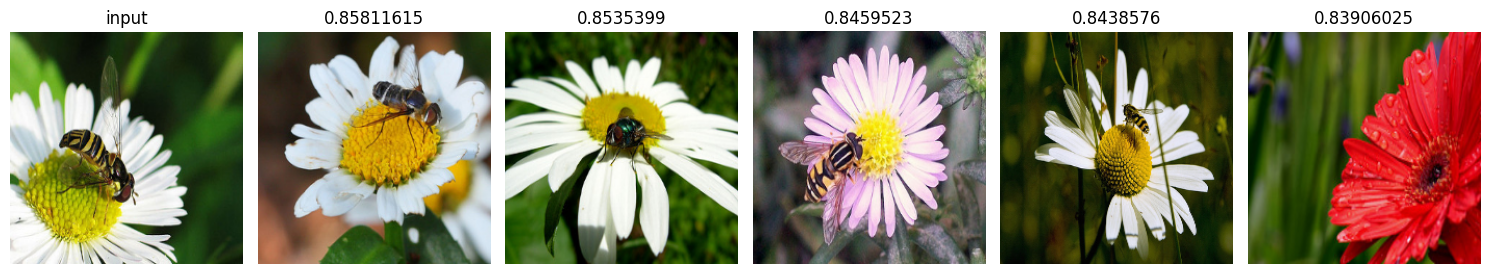

In [226]:
input_path = "flowers\\daisy\\5547758_eea9edfd54_n.jpg"
similar_items = find_similar_images(query_image_path=input_path, model=model)
display_images(input_path, similar_items)